In [221]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import preprocessing

In [238]:
#data = pd.read_parquet("data/3-Rbot-20110812.binetflow.parquet")
data = pd.read_csv("capture20110815-3.binetflow")

In [223]:
data.shape

(1925149, 15)

In [224]:
data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/15 17:13:40.449530,504.234436,tcp,90.177.154.197,20127,<?>,147.32.84.144,22,FPA_FPA,0.0,0.0,25518,24184088,681036,flow=Background
1,2011/08/15 17:13:40.453458,1052.854126,tcp,198.36.38.132,55530,<?>,147.32.86.183,443,FPA_FPA,0.0,0.0,37113,8107174,825680,flow=Background
2,2011/08/15 17:13:40.456275,1046.228882,udp,41.103.64.21,54617,<->,147.32.86.183,51246,CON,0.0,0.0,24471,6638214,6634822,flow=Background-UDP-Established
3,2011/08/15 17:13:40.462030,3599.993896,tcp,147.32.80.13,80,<?>,147.32.84.162,60840,PA_A,0.0,0.0,77144,61919076,60398556,flow=From-Background-CVUT-Proxy
4,2011/08/15 17:13:40.464134,3599.980225,tcp,83.163.158.159,65400,<?>,147.32.84.171,6881,PA_PA,0.0,0.0,269868,256890904,5818939,flow=Background


In [225]:
data.isnull().sum()

StartTime         0
Dur               0
Proto             0
SrcAddr           0
Sport         26281
Dir               0
DstAddr           0
Dport         10125
State             1
sTos          27079
dTos         121810
TotPkts           0
TotBytes          0
SrcBytes          0
Label             0
dtype: int64

In [239]:
data = data.dropna()

In [240]:
data = data.drop(['StartTime', 'SrcAddr', 'DstAddr'], axis=1)

In [241]:
def crete_bool_label(input_flow):
    if "Botnet" in input_flow:
        return 1
    else:
        return 0
    
data["Label"] = data["Label"].apply(crete_bool_label)


In [242]:
data.Label.value_counts()

0    1745096
1      32467
Name: Label, dtype: int64

In [232]:
data.head()

,Dur,Proto,Sport,Dir,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,504.234436,tcp,20127,<?>,22,FPA_FPA,0.0,0.0,25518,24184088,681036,0
1,1052.854126,tcp,55530,<?>,443,FPA_FPA,0.0,0.0,37113,8107174,825680,0
2,1046.228882,udp,54617,<->,51246,CON,0.0,0.0,24471,6638214,6634822,0
3,3599.993896,tcp,80,<?>,60840,PA_A,0.0,0.0,77144,61919076,60398556,0
4,3599.980225,tcp,65400,<?>,6881,PA_PA,0.0,0.0,269868,256890904,5818939,0


In [243]:
data = data[data["Dir"].str.contains("\?") == False]
data = data[data["Proto"].str.contains("ipnip|llc|unas|udt|pim|ipx/spx|ipv6-icmp|ipv6|igmp|rtp|rtcp|arp") == False]

In [248]:
value_counts_state = data.State.value_counts()
value_counts_dir= data.Dir.value_counts()

threshold_count = 1000 

filtered_values_state = value_counts_state[value_counts_state >= threshold_count].index
filtered_values_dir = value_counts_dir[value_counts_dir >= threshold_count].index

data = data[data.State.isin(filtered_values_state)]
data = data[data.Dir.isin(filtered_values_dir)]

In [249]:
print(data.State.value_counts())

CON           1467809
FSPA_FSPA      167135
S_RA            32262
SRPA_FSPA       26015
FSA_FSA         14457
FSRPA_FSPA      12645
SRPA_SPA         7572
S_SA             7407
SA_R             4352
FSPA_FSRPA       3432
SR_SA            2815
SPA_SPA          2526
ECO              2287
SPA_FSPA         2020
FSA_FSPA         1666
SRA_SA           1557
FSRPA_SPA        1515
PA_PA            1257
SPA_SRPA         1123
FSPA_FSA         1076
Name: State, dtype: int64


In [251]:

data.State.value_counts()

CON           1467809
FSPA_FSPA      167135
S_RA            32262
SRPA_FSPA       26015
FSA_FSA         14457
FSRPA_FSPA      12645
SRPA_SPA         7572
S_SA             7407
SA_R             4352
FSPA_FSRPA       3432
SR_SA            2815
SPA_SPA          2526
ECO              2287
SPA_FSPA         2020
FSA_FSPA         1666
SRA_SA           1557
FSRPA_SPA        1515
PA_PA            1257
SPA_SRPA         1123
FSPA_FSA         1076
Name: State, dtype: int64

In [252]:
#data = data.dropna(subset=['Sport', 'Dport'])
data.loc[data['Dport'].str.contains('0x'), 'Dport'] = 0
data.loc[data['Sport'].str.contains('0x'), 'Sport'] = 0
data['Sport'] = data['Sport'].astype('int')
data['Dport'] = data['Dport'].astype('int')

In [253]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760928 entries, 2 to 1925145
Data columns (total 12 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Dur       float64
 1   Proto     object 
 2   Sport     int32  
 3   Dir       object 
 4   Dport     int32  
 5   State     object 
 6   sTos      float64
 7   dTos      float64
 8   TotPkts   int64  
 9   TotBytes  int64  
 10  SrcBytes  int64  
 11  Label     int64  
dtypes: float64(3), int32(2), int64(4), object(3)
memory usage: 161.2+ MB


In [254]:
labe_enc = LabelEncoder()
data['Label'] = labe_enc.fit_transform(data['Label'])
data = pd.get_dummies(data)
data.describe()

,Dur,Sport,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Proto_icmp,...,State_SA_R,State_SPA_FSPA,State_SPA_SPA,State_SPA_SRPA,State_SRA_SA,State_SRPA_FSPA,State_SRPA_SPA,State_SR_SA,State_S_RA,State_S_SA
count,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06,...,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06,1.760928e+06
mean,3.239870e+02,3.836834e+04,7.061462e+03,2.006328e-03,4.560096e-04,2.376670e+01,1.720195e+04,2.301487e+03,1.840166e-02,1.298747e-03,...,2.471424e-03,1.147122e-03,1.434471e-03,6.377319e-04,8.841929e-04,1.477346e-02,4.300005e-03,1.598589e-03,1.832102e-02,4.206305e-03
std,8.816006e+02,1.881102e+04,1.146551e+04,7.144284e-02,3.432417e-02,2.021703e+03,1.926055e+06,6.341450e+05,1.343988e-01,3.601473e-02,...,4.965196e-02,3.384977e-02,3.784725e-02,2.524531e-02,2.972224e-02,1.206450e-01,6.543331e-02,3.995040e-02,1.341096e-01,6.471950e-02
min,2.000000e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.200000e+02,6.000000e+01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.760000e-04,2.191100e+04,5.300000e+01,0.000000e+00,0.000000e+00,2.000000e+00,2.140000e+02,7.800000e+01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.950000e-04,4.304400e+04,8.000000e+01,0.000000e+00,0.000000e+00,2.000000e+00,2.700000e+02,8.100000e+01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.687177e-01,5.385700e+04,1.336300e+04,0.000000e+00,0.000000e+00,4.000000e+00,6.120000e+02,2.340000e+02,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.600000e+03,6.553500e+04,6.553500e+04,3.000000e+00,3.000000e+00,1.185896e+06,1.403006e+09,5.055238e+08,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [255]:

def slicing(data):
    df_majority = data[data['Label'] == 0]
    df_minority = data[data['Label'] == 1]
    undersampled_majority = resample(df_majority,
                    replace=False, # Set to False for undersampling
                    n_samples=len(df_minority), # Match the number of samples in the minority class
                    random_state=42) # Set random shuffle
    undersampled_df = pd.concat([undersampled_majority, df_minority])
    undersampled_df = undersampled_df.sample(frac=1,random_state=42).reset_index(drop=True)
    reserv_data = undersampled_df
    y = undersampled_df.Label
    undersampled_df = undersampled_df.drop(["Label"], axis=1)
    return undersampled_df, y, reserv_data

X_data, y_label, data2 = slicing(data)


In [256]:
X_data.head()

,Dur,Sport,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,Proto_icmp,Proto_tcp,...,State_SA_R,State_SPA_FSPA,State_SPA_SPA,State_SPA_SRPA,State_SRA_SA,State_SRPA_FSPA,State_SRPA_SPA,State_SR_SA,State_S_RA,State_S_SA
0,0.069790,13363,57021,0.0,0.0,2,120,60,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.306928,2163,443,0.0,0.0,6,366,186,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0.000186,46350,53,0.0,0.0,2,214,81,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17.723129,49618,80,0.0,0.0,8,492,246,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.175398,1278,53,0.0,0.0,2,438,87,0,0,...,0,0,0,0,0,0,0,0,0,0


In [257]:
data2.head()

,Dur,Sport,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Proto_icmp,...,State_SA_R,State_SPA_FSPA,State_SPA_SPA,State_SPA_SRPA,State_SRA_SA,State_SRPA_FSPA,State_SRPA_SPA,State_SR_SA,State_S_RA,State_S_SA
0,0.069790,13363,57021,0.0,0.0,2,120,60,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.306928,2163,443,0.0,0.0,6,366,186,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0.000186,46350,53,0.0,0.0,2,214,81,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17.723129,49618,80,0.0,0.0,8,492,246,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.175398,1278,53,0.0,0.0,2,438,87,1,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

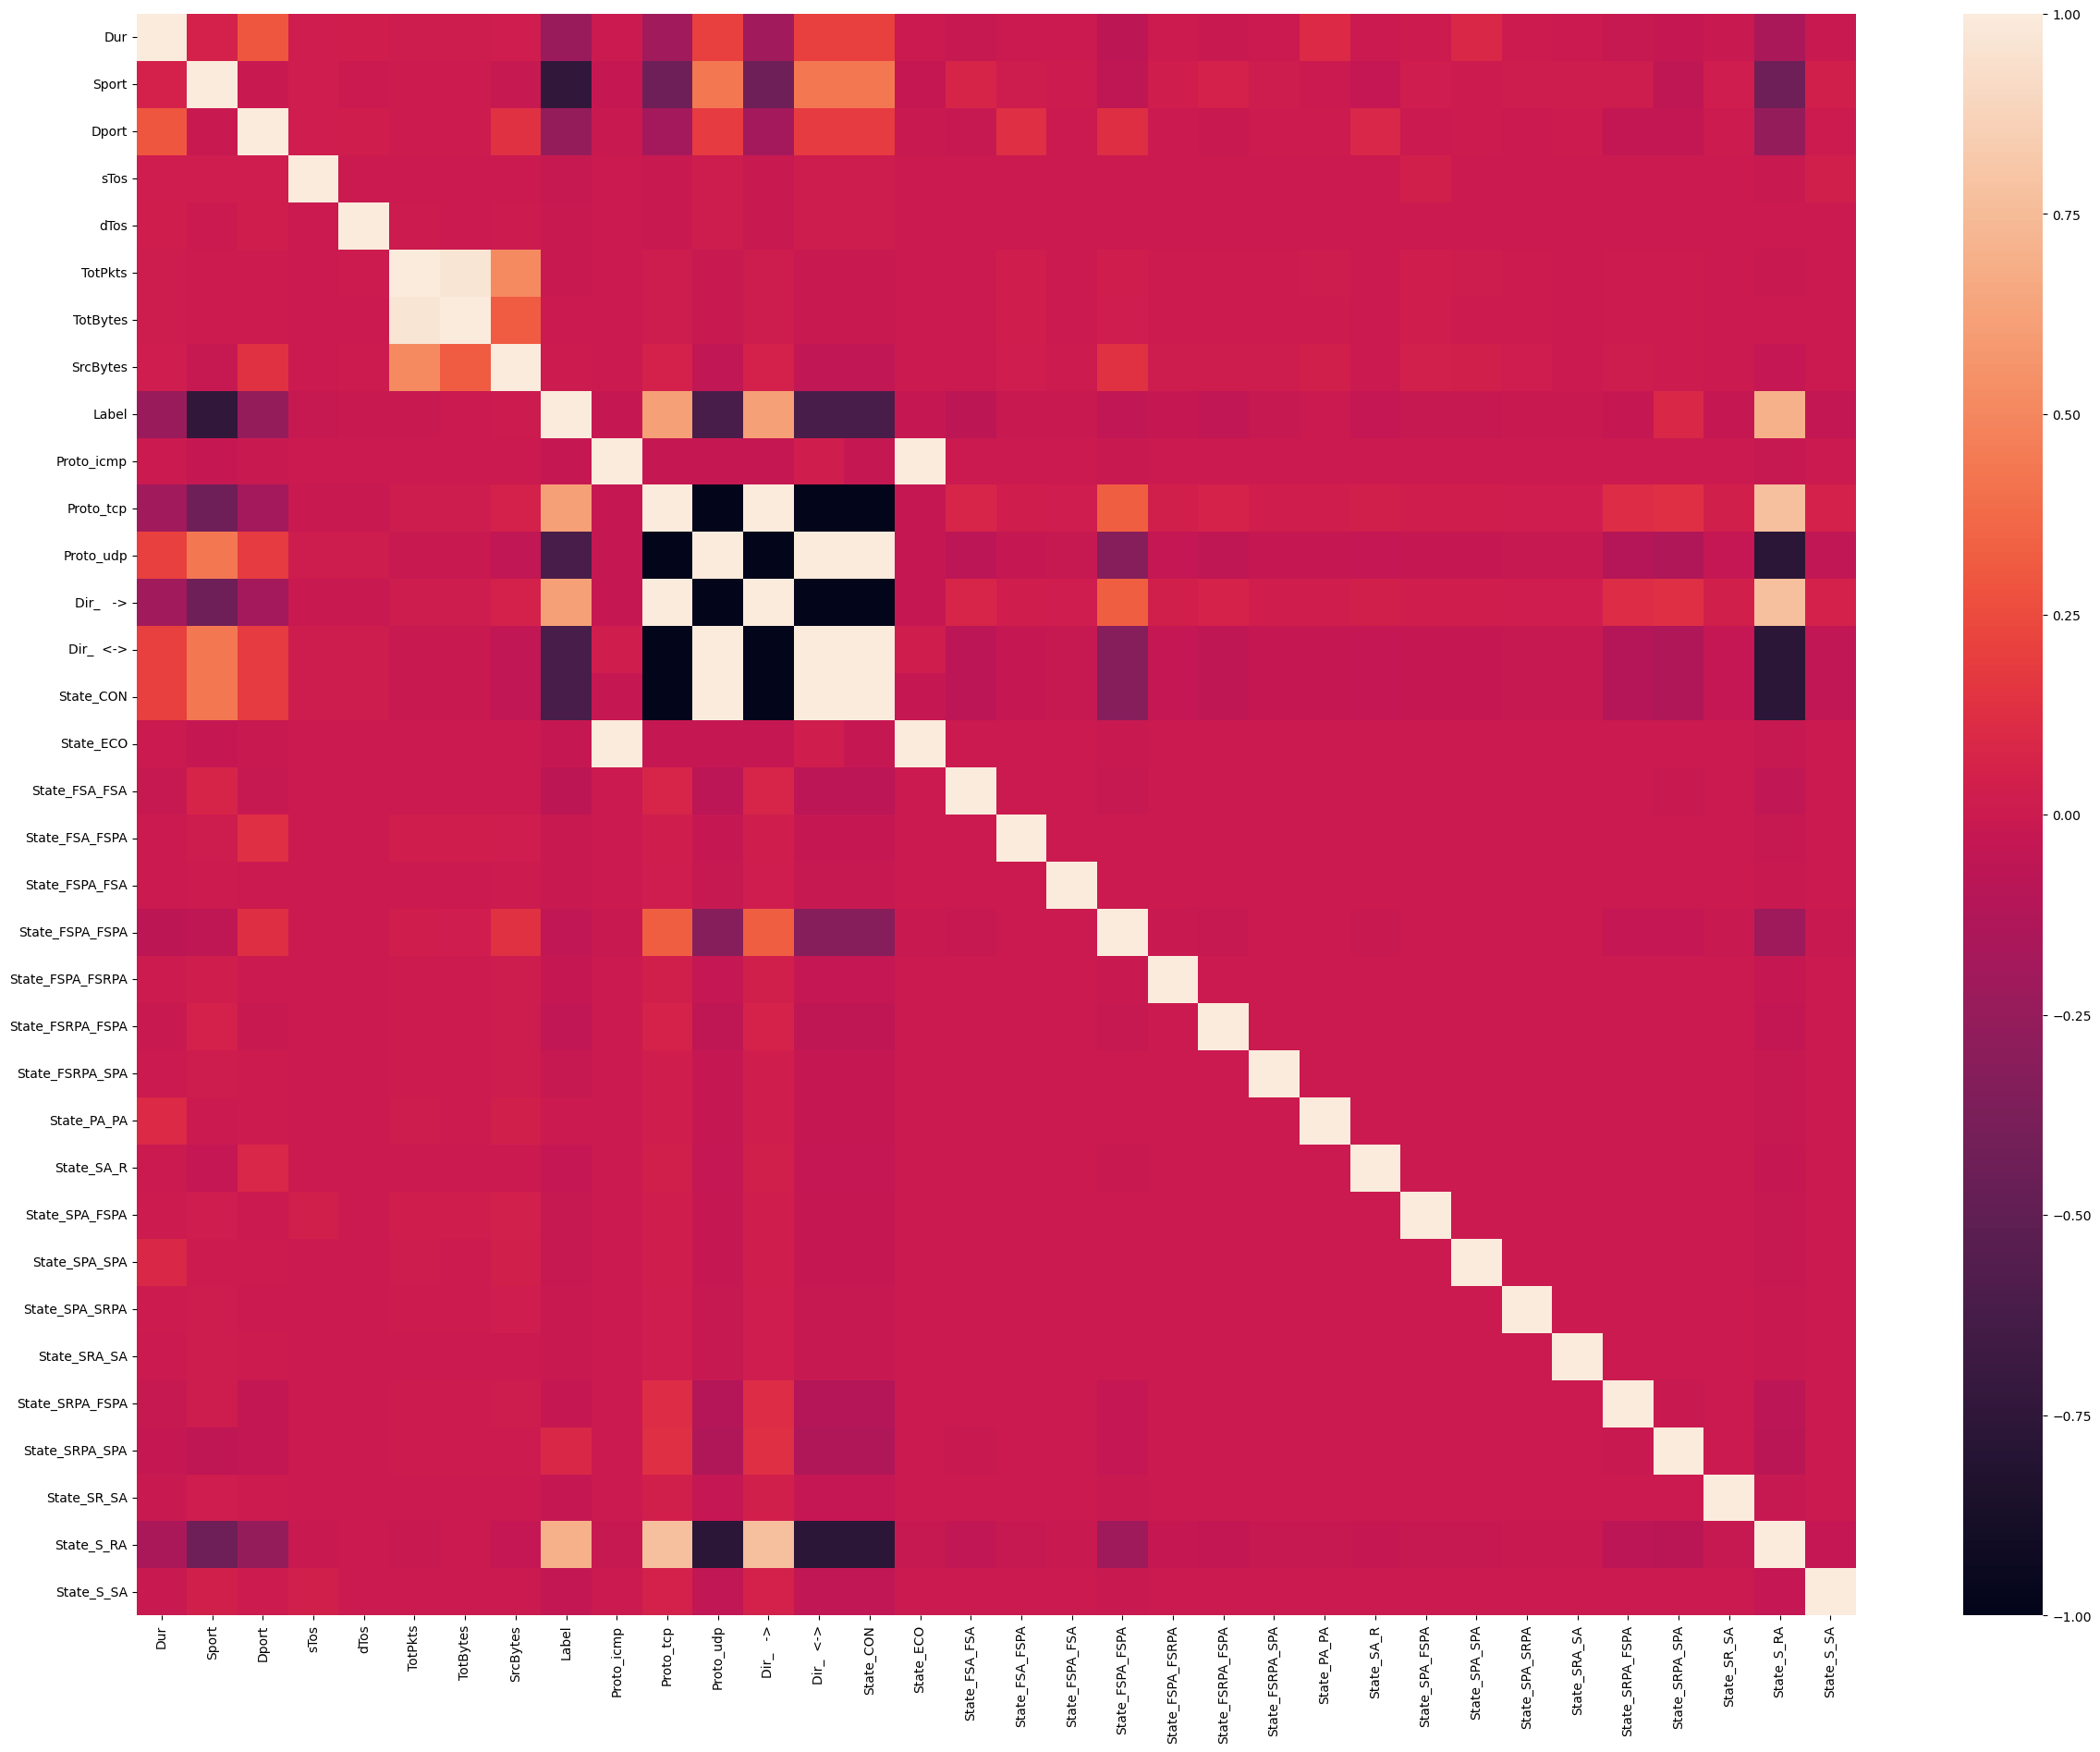

In [258]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(30,22.5))
sns.heatmap(data2.corr())

In [259]:
is_claim_correlations = data2.corr()['Label'].abs().sort_values()
is_claim_correlations

SrcBytes            0.004140
State_PA_PA         0.005557
TotBytes            0.007028
TotPkts             0.008422
State_FSPA_FSA      0.008576
dTos                0.010927
State_FSA_FSPA      0.011848
State_SPA_SRPA      0.012328
State_SRA_SA        0.015322
State_SPA_SPA       0.020215
sTos                0.021329
State_FSRPA_SPA     0.021828
State_SPA_FSPA      0.023040
State_FSPA_FSRPA    0.026221
State_ECO           0.026651
Proto_icmp          0.026651
State_SRPA_FSPA     0.029345
State_SR_SA         0.030754
State_SA_R          0.034265
State_S_SA          0.046695
State_FSPA_FSPA     0.051629
State_FSRPA_FSPA    0.052231
State_FSA_FSA       0.065051
State_SRPA_SPA      0.088651
Dur                 0.233595
Dport               0.257301
State_CON           0.615112
Proto_udp           0.615112
Dir_  <->           0.616604
Dir_   ->           0.616604
Proto_tcp           0.616604
State_S_RA          0.697511
Sport               0.735666
Label               1.000000
Name: Label, d

In [260]:
features = is_claim_correlations[is_claim_correlations > 0.1].axes[0][::-1]
features = features.drop(['Label'])
features

Index(['Sport', 'State_S_RA', 'Proto_tcp', 'Dir_   ->', 'Dir_  <->',
       'Proto_udp', 'State_CON', 'Dport', 'Dur'],
      dtype='object')

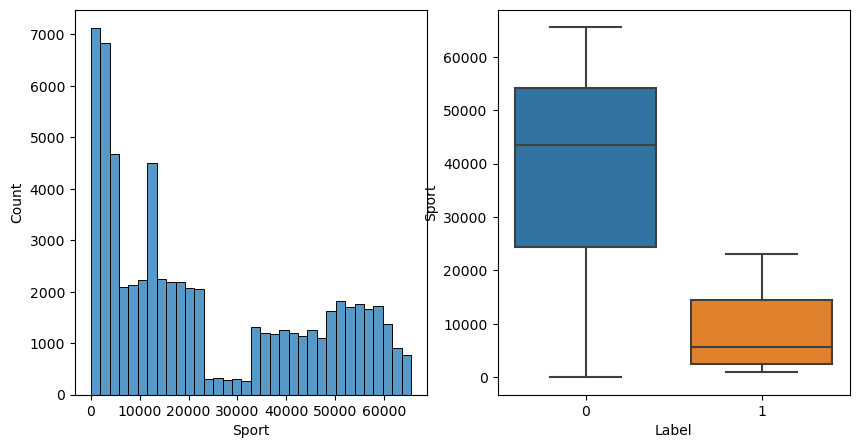

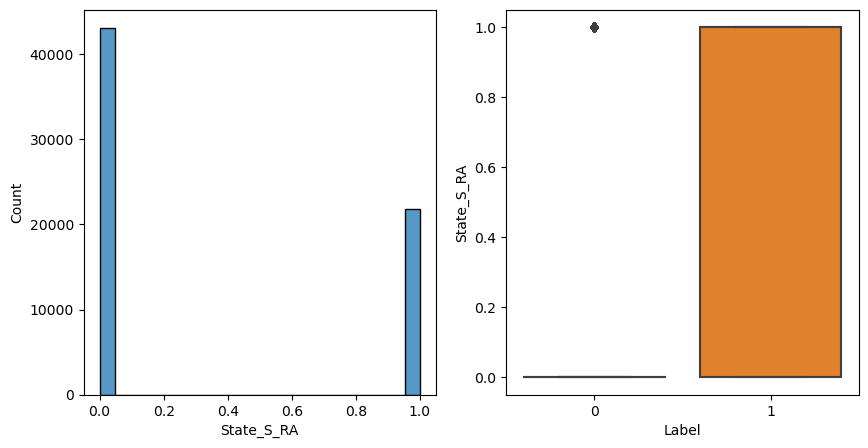

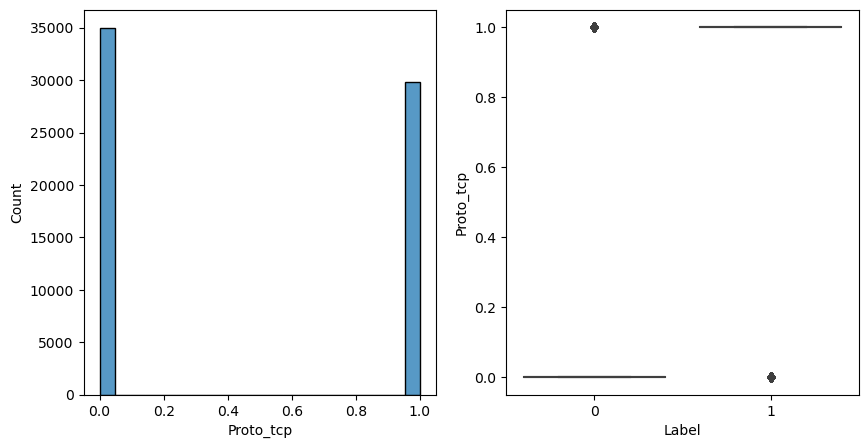

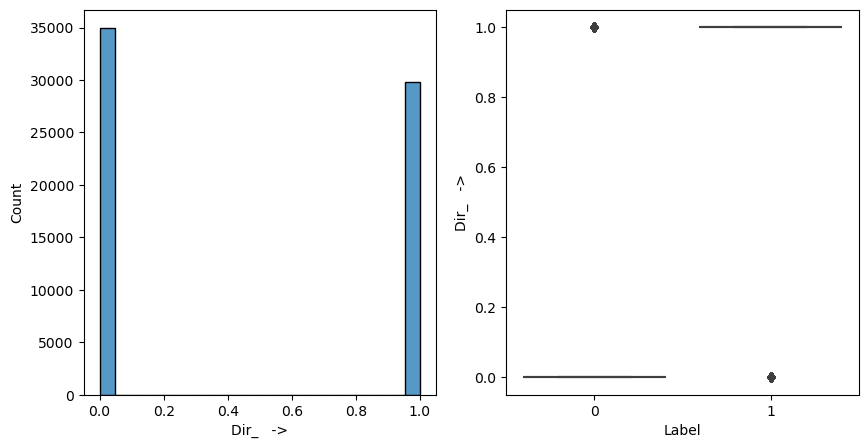

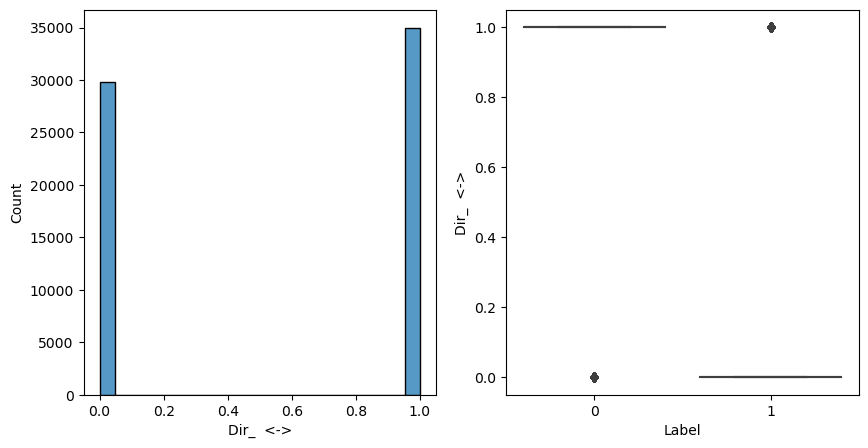

In [262]:
for feature in features[:5]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.histplot(data2[feature], ax=ax1)
    sns.boxplot(x=data2['Label'],y=data2[feature], ax=ax2)
    plt.show()

In [263]:
# X = data.drop(columns=['booking_status'])
# X = data[features]
# y = data['booking_status']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_data,y_label, train_size=0.8, test_size=0.2)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)


In [264]:
k_values = {}
for k in range(5,30):
    kNN_classifier = KNeighborsClassifier(n_neighbors=k)
    kNN_classifier.fit(X_train_scaled, y_train)
    k_values[k] = kNN_classifier.score(X_test_scaled, y_test)
    #print(kNN_classifier.score(X_test_scaled, y_test))
print(k_values)

{5: 0.9949853417682456, 6: 0.994831044591884, 7: 0.9945995988273415, 8: 0.9941367072982564, 9: 0.9936738157691715, 10: 0.9933652214164481, 11: 0.9930566270637248, 12: 0.992902329887363, 13: 0.9923622897700972, 14: 0.9921308440055547, 15: 0.9911279123592038, 16: 0.9912050609473847, 17: 0.9901249807128529, 18: 0.9902021293010338, 19: 0.9898163863601296, 20: 0.9899706835364913, 21: 0.9895849405955871, 22: 0.9891991976546829, 23: 0.9890449004783213, 24: 0.9889677518901404, 25: 0.989122049066502, 26: 0.9890449004783213, 27: 0.9889677518901404, 28: 0.9889677518901404, 29: 0.9890449004783213}


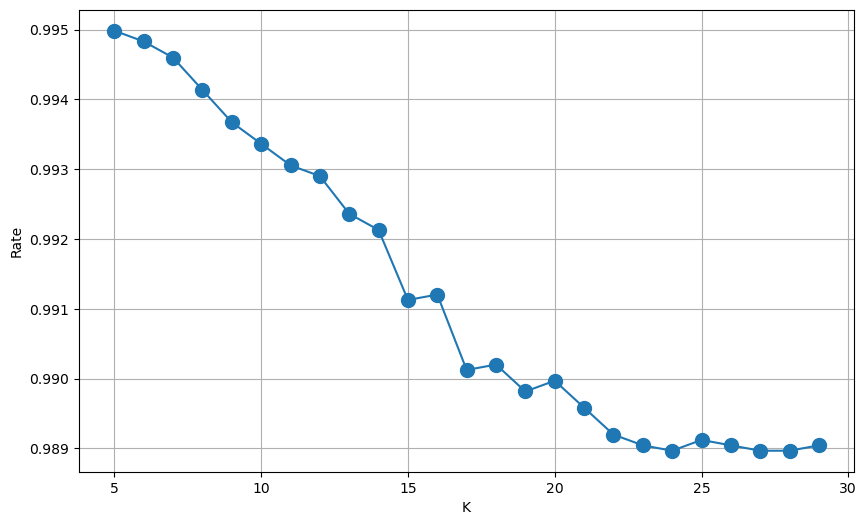

In [270]:
plt.figure(figsize=(10,6))
plt.plot(list(k_values.keys()), list(k_values.values()), marker='o', markersize=10)
plt.xlabel('K')
plt.ylabel('Rate')
plt.grid()

In [271]:
kNN_classifier = KNeighborsClassifier(n_neighbors=5)
kNN_classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [272]:
tree_classifier = DecisionTreeClassifier(max_depth=10)
tree_classifier.fit(X_train_scaled, y_train)
tree_classifier.score(X_test_scaled, y_test)

0.9947538960037031

In [216]:
grid_for_svm = [
    {'C': [0.1, 1, 10], 'kernel': ['poly', 'sigmoid']},
    {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'gamma': [0.01, 0.1, 0.5]}
]
svm_grid_classifier = sklearn.model_selection.GridSearchCV(SVC(), grid_for_svm, cv = 2,  verbose=3)
svm_grid_classifier.fit(X_train_scaled, y_train)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV 1/2] END ................C=0.1, kernel=poly;, score=0.965 total time=  26.8s
[CV 2/2] END ................C=0.1, kernel=poly;, score=0.967 total time=  27.0s
[CV 1/2] END .............C=0.1, kernel=sigmoid;, score=0.946 total time=  45.8s
[CV 2/2] END .............C=0.1, kernel=sigmoid;, score=0.942 total time=  52.0s
[CV 1/2] END ..................C=1, kernel=poly;, score=0.965 total time=  11.1s
[CV 2/2] END ..................C=1, kernel=poly;, score=0.969 total time=  11.2s
[CV 1/2] END ...............C=1, kernel=sigmoid;, score=0.941 total time=  12.8s
[CV 2/2] END ...............C=1, kernel=sigmoid;, score=0.939 total time=  11.6s
[CV 1/2] END .................C=10, kernel=poly;, score=0.977 total time=   5.8s
[CV 2/2] END .................C=10, kernel=poly;, score=0.979 total time=   6.6s
[CV 1/2] END ..............C=10, kernel=sigmoid;, score=0.937 total time=   9.7s
[CV 2/2] END ..............C=10, kernel=sigmoid;

GridSearchCV(cv=2, estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['poly', 'sigmoid']},
                         {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 0.5],
                          'kernel': ['rbf']}],
             verbose=3)

In [273]:
print(svm_grid_classifier.best_params_)
print(svm_grid_classifier.score(X_test_scaled, y_test))

{'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.9831816077765777


In [274]:
forest_classifier = RandomForestClassifier(n_estimators=50, max_depth=10)
forest_classifier.fit(X_train_scaled, y_train)
forest_classifier.score(X_test_scaled, y_test)

0.995756827650054

In [275]:
ada_classifier = AdaBoostClassifier(n_estimators=50)
ada_classifier.fit(X_train_scaled, y_train)
ada_classifier.score(X_test_scaled, y_test)

0.9917451010646505

In [276]:
classifiers = [kNN_classifier, tree_classifier, svm_grid_classifier, forest_classifier, ada_classifier]
for classifier in classifiers:
    print(classifier)
    print(sklearn.metrics.classification_report(y_test, classifier.predict(X_test_scaled)))
    print(sklearn.metrics.confusion_matrix(y_test, classifier.predict(X_test_scaled)))


KNeighborsClassifier()
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6482
           1       0.99      1.00      0.99      6480

    accuracy                           0.99     12962
   macro avg       1.00      0.99      0.99     12962
weighted avg       1.00      0.99      0.99     12962

[[6431   51]
 [  14 6466]]
DecisionTreeClassifier(max_depth=10)
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6482
           1       0.99      1.00      0.99      6480

    accuracy                           0.99     12962
   macro avg       0.99      0.99      0.99     12962
weighted avg       0.99      0.99      0.99     12962

[[6419   63]
 [   5 6475]]
GridSearchCV(cv=2, estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['poly', 'sigmoid']},
                         {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 0.5],
                          'kernel': ['rbf']}],
